Based on Mads Ry Jørgensen's notebook from the [DanMAX beamline @ MAX IV](http://maxiv.lu.se/danmax)

# How to work with your integrated data

You can use this notbook as inspiration to help you process your data and quicly prepare plots

The only required input for a I vs. tth/q or simple waterfall plot is the path for the `.h5` master file.

### Contents:
[**Plot a normal diffractogram**](#plot_pxrd)  
[**Extracting other measurement data**](#extract_meta)  
[**Plotting a specific section of the water fall plot**](#waterfall)  
[**Generate waterfall plot with temperture profile**](#waterfall_temp)  
[**Fit a single peak in your diffraction data with a Gaussian function**](#single_peak_fit)  
[**Fit a single peak in a range frames with a Gaussian functions**](#single_peak_fit_range)  
[**Clean up 'missing' data**](#clean_up)  

In [1]:
# %matplotlib widget
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
print('Current visit directory:')
# print(f"'{os.getcwd().split('/scripts')[0]}'")
print(f"'{os.getcwd()}'")

Current visit directory:
'/Users/yuewu/Library/CloudStorage/GoogleDrive-digression@gmail.com/My Drive/SLAC/conference/APDW2022/data3'


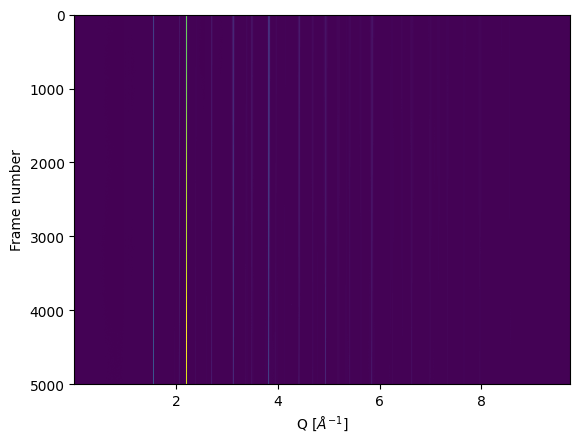

In [2]:
# Insert path for the .h5 file - TIP: Use tap for auto-complete
fname = 'scan-2138.h5'

# Create azint filename from master file name
azint_fname = fname.replace('raw', 'process/azint').split('.')[0]+'_pilatus_integrated.h5'

# Open azint file and extract integrated intensities
azint_file = h5py.File(azint_fname, 'r')
azint_data = azint_file['I']

# Determine if the file is integrated in tth or q
try:
    r_unit = azint_file['2th']
    tth = True
except KeyError:
    r_unit = azint_file['q']
    tth = False

# Generate and show the waterfall plot
plt.figure()
plt.imshow(azint_data, extent=[r_unit[0], r_unit[-1], azint_data.shape[0], 0], interpolation = 'Nearest', aspect = 'auto')
plt.ylabel('Frame number')
if tth:
    plt.xlabel(r'2$\theta$ [$\deg$]')
else:
    plt.xlabel(r'Q [$\AA^{-1}$]')

#### Plot a normal diffractogram <a id='plot_pxrd'></a>

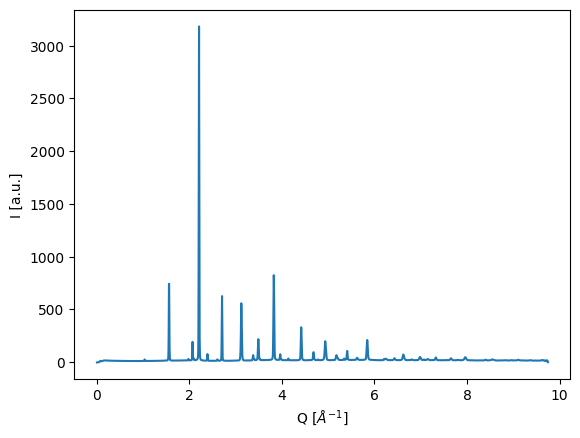

In [3]:
frame_no = int(azint_data.shape[0]/2) #Some integer - this case half way through
plt.figure()
plt.plot(r_unit[:], azint_data[frame_no, :])
plt.ylabel('I [a.u.]')
if tth:
    plt.xlabel(r'2$\theta$ [$\deg$]')
else:
    plt.xlabel(r'Q [$\AA^{-1}$]')

#### Extracting other measurement data <a id='extract_meta'></a>
In this example the temperature from either the LakeShore temperature controller is extraced (chanel C) or the cryostream and plotted.

Change the `temperature_data_name` to suit your needs

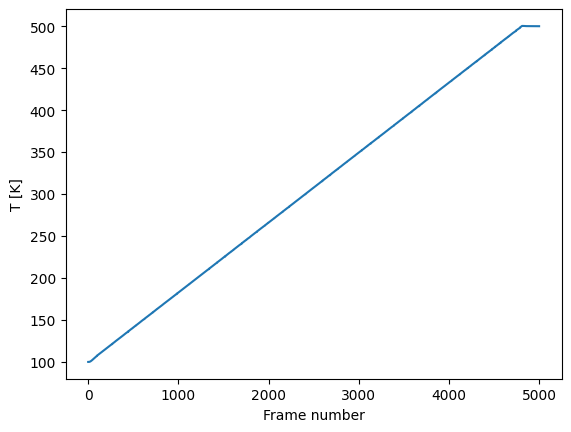

In [4]:
# Open master file and extract temperature data
file = h5py.File(fname, 'r')

#temperature_data_name = 'lakeshore_tempC' # LakeShore chanel C
temperature_data_name = 'cryo_temp' # Cryostream

try:
    temperature = file['entry/instrument/'+temperature_data_name+'/data']
   
    # Plot
    plt.figure()
    plt.plot(temperature[:])
    plt.xlabel('Frame number')
    plt.ylabel('T [K]')
except KeyError:
    print('It seems that data for {0} was not collected!'.format(temperature_data_name))

#### Extracting other measurement data - continued...
In this example the data from the Alba electrometer is extracted. Some of these may be used for normalization of either the raw data or the integrated data

Change the `data_name` to suit your needs

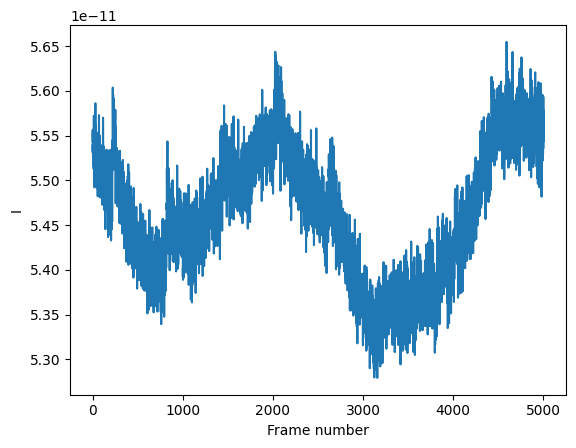

In [5]:
# Extract normalization data

# Using PXRD2D measurement group
#data_name = 'albaem-01_ch3' # Intenisty montor (downstream of monos) in optics hutch
data_name = 'albaem-xrd_ch3' # Intensity monitor after guard slits

try:
    intensity = file['entry/instrument/'+data_name+'/data']
   
    # Plot
    plt.figure()
    plt.plot(intensity[:])
    plt.xlabel('Frame number')
    plt.ylabel('I')
except KeyError:
    print('It seems that data for {0} was not collected!'.format(data_name))

#### Plotting a specific section of the water fall plot <a id='waterfall'></a>
In this example it is shown how to select a smaller range in both frame number and angular range - and how to update the axis to match the new selection

The `vmax`, `frame_range` and `angular_range` parameters will likely need to be tweaked

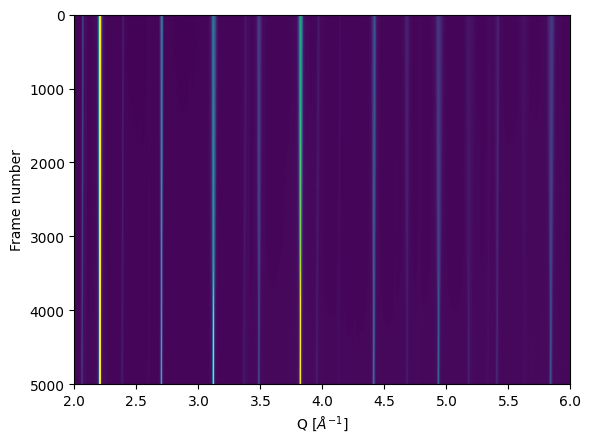

In [6]:
# Generate and show a section the waterfall plot with clipped color scale

# Set ranges
frame_range = [0,5000]
angular_range = [2, 6]

# Calculate indexes for angular ranges
index_range = [np.where(r_unit[:]>angular_range[0])[0][0], np.where(r_unit[:]<angular_range[1])[0][-1]]

# Generate and plot
plt.figure()
plt.imshow(azint_data[frame_range[0]:frame_range[1],index_range[0]:index_range[1]], vmin=0, vmax=0.3*np.max(azint_data), extent=[angular_range[0], angular_range[1], frame_range[1], frame_range[0]], interpolation = 'Nearest', aspect = 'auto')
plt.ylabel('Frame number')
if tth:
    plt.xlabel(r'2$\theta$ [$\deg$]')
else:
    plt.xlabel(r'Q [$\AA^{-1}$]')

#### Generate waterfall plot with temperature profile <a id='waterfall_temp'></a>
In this example the section of the waterfall plot obove is plotted together with the temperature profile

The `vmax` parameter will likely need to be tweaked

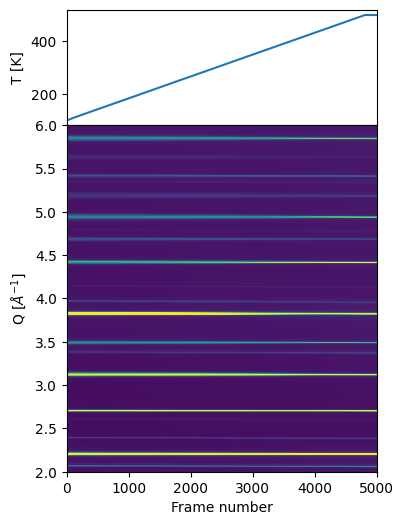

In [7]:
# Set up the subplot axis
fig, axes = plt.subplots(2,1, figsize=(4,6), gridspec_kw={'height_ratios': [1, 3]})

# Plot tempaerate in the proper range, and remove x-axis
axes[0].plot(np.linspace(frame_range[0],frame_range[1],frame_range[1]-frame_range[0]), temperature[frame_range[0]:frame_range[1]])
axes[0].set(ylabel='T [K]')
axes[0].set(xlim=(frame_range[0],frame_range[1]))
axes[0].get_xaxis().set_visible(False)

# Show the proper section of the waterfall plot - rotated 90 degrees!
axes[1].imshow(np.rot90(azint_data[frame_range[0]:frame_range[1],index_range[0]:index_range[1]]), vmin=0, vmax=0.1*np.max(azint_data), extent=[frame_range[0], frame_range[1], angular_range[0], angular_range[1]], interpolation = 'Nearest', aspect = 'auto')
axes[1].set(xlabel='Frame number')
axes[1].set(ylabel='T [K]')
if tth:
    axes[1].set(ylabel=r'2$\theta$ [$\deg$]')
else:
    axes[1].set(ylabel=r'Q [$\AA^{-1}$]')

# Remove space between the plots
plt.subplots_adjust(wspace=0, hspace=0)

### Fit a single peak in your diffraction data with a Gaussian function <a id='single_peak_fit'></a>

This will only work (well) with one peak in the window defined using the `lim_low` and `lim_high`. The frame used for the fitting is specified in `frame_no`

FWHM: 0.0125963331344087 AA^-1


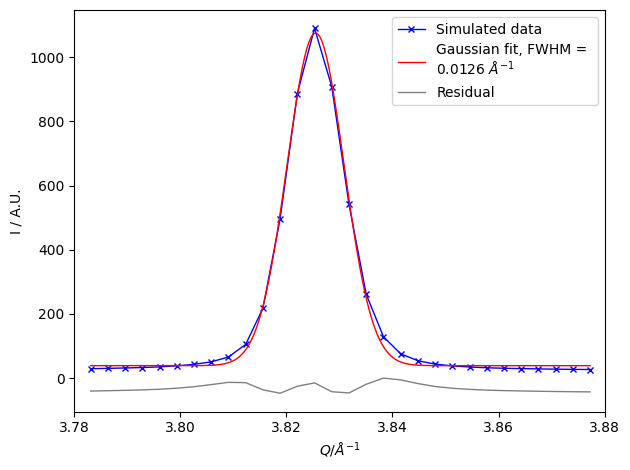

In [8]:
lim_low = 3.78
lim_high = 3.88
frame_no = 4000

import scipy.optimize as sci_op

# Peak profile - in this case gaussian
def gauss(x,a,x0,sigma,b):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+b

# Slice data
r_unit[:], azint_data[frame_no, :]
peak_r = r_unit[:][(r_unit[:] > lim_low) & (r_unit[:] < lim_high)]
peak_I = azint_data[frame_no,:][(r_unit[:] > lim_low) & (r_unit[:] < lim_high)]


# Find center for initial parameter guess
center = peak_r[np.argmax(peak_I)]
# Guess for background
guess_b = (peak_I[0]+peak_I[-1])/2
# Guess for sigma based on estimate of FWHM from array
guess_sigma = (peak_r[np.where(peak_I-guess_b > np.max(peak_I-guess_b)/2)[0][-1]]-peak_r[np.where(peak_I-guess_b > np.max(peak_I-guess_b)/2)[0][0]])/(2*np.sqrt(2*np.log(2)))

# Assume convergance before fit
convergance = True

# Fit the peak
try:
    popt,pcov = sci_op.curve_fit(gauss,peak_r,peak_I,p0=[np.max(peak_I)-guess_b,center,guess_sigma,guess_b])
except RuntimeError:
    print('sum(X) fit did not converge!')
    convergance = False

# Print FWHM
if convergance:
    if tth:
        print("FWHM: {0} degrees".format(2*np.sqrt(2*np.log(2))*popt[2]))
    else:
        print("FWHM: {0} AA^-1".format(2*np.sqrt(2*np.log(2))*popt[2]))

        #Create a theta/q vector with fine intervals for plotting
fine_r = np.linspace(peak_r[0], peak_r[-1], 500)

# Plot the data and the fitting reults   
plt.figure()
plt.plot(peak_r, peak_I, 'bx-', label = 'Simulated data', linewidth = 1, markersize=4)
if convergance:
    if tth:
        plt.plot(fine_r, gauss(fine_r,*popt), 'r-', linewidth = 1, label = 'Gaussian fit, FWHM = \n{0:.4f} $\degree$'.format(2*np.sqrt(2*np.log(2))*popt[2]))
    else:
        plt.plot(fine_r, gauss(fine_r,*popt), 'r-', linewidth = 1, label = 'Gaussian fit, FWHM = \n{0:.4f} $\AA^{1}$'.format(2*np.sqrt(2*np.log(2))*popt[2], '{-1}'))
    plt.plot(peak_r, peak_I-gauss(peak_r,*popt)-np.max(peak_I-gauss(peak_r,*popt)), 'grey', linewidth = 1, label = 'Residual')

plt.legend()
plt.ylabel('I / A.U.')
if tth:
    plt.xlabel(r'$2\theta /\degree$')
else:
    plt.xlabel(r'$Q /\AA^{-1}$')
plt.xlim(lim_low, lim_high)
plt.tight_layout()

### Fit a single peak in a range frames with a Gaussian functions  <a id='single_peak_fit_range'></a>

This will only work (well) with one peak in the window defined using the `lim_low` and `lim_high`. The frame used for the fitting is specified in `frames`

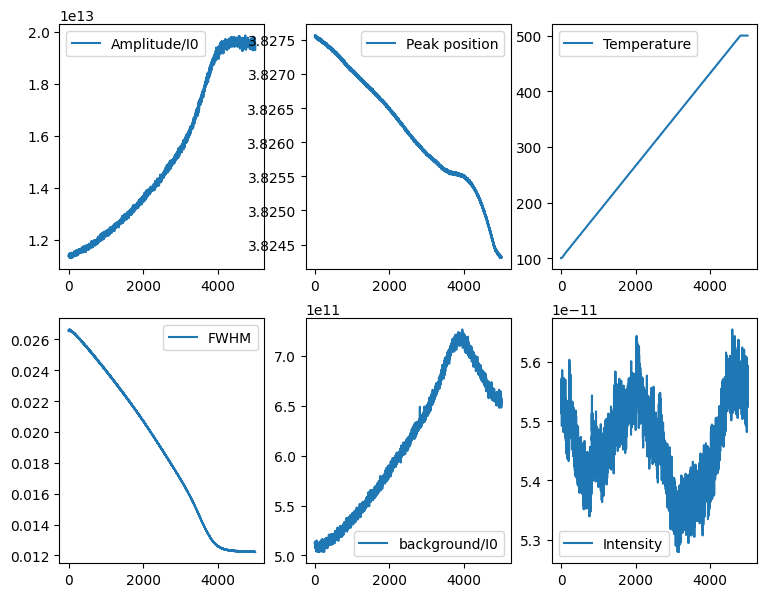

In [9]:
import scipy.optimize as sci_op

# Peak definitions - limits in degrees/AA^-1
lim_low = 3.78
lim_high = 3.88

frames = [0, 5000]

# Peak profile - in this case gaussian
def gauss(x,a,x0,sigma,b):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+b

amplitude = []
position = []
fwhm = []
background = []

for i in range(frames[0],frames[1]):
    
    # Slice data
    r_unit[:], azint_data[i, :]
    peak_r = r_unit[:][(r_unit[:] > lim_low) & (r_unit[:] < lim_high)]
    peak_I = azint_data[i,:][(r_unit[:] > lim_low) & (r_unit[:] < lim_high)]

    # Find center for initial parameter guess
    center = peak_r[np.argmax(peak_I)]
    
    # Guess for background
    guess_b = (peak_I[0]+peak_I[-1])/2

    # Guess for sigma based on estimate of FWHM from array
    guess_sigma = (peak_r[np.where(peak_I-guess_b > np.max(peak_I-guess_b)/2)[0][-1]]-peak_r[np.where(peak_I-guess_b > np.max(peak_I-guess_b)/2)[0][0]])/(2*np.sqrt(2*np.log(2)))

    # Assume convergance before fit
    convergance = True

    # Fit the peak
    try:
        popt,pcov = sci_op.curve_fit(gauss,peak_r,peak_I,p0=[np.max(peak_I)-guess_b,center,guess_sigma,guess_b])
    except RuntimeError:
        print('sum(X) fit did not converge!')
        convergance = False

    
    amplitude.append(popt[0])
    position.append(popt[1])
    fwhm.append(2*np.sqrt(2*np.log(2))*popt[2])
    background.append(popt[3])

amplitude = np.array(amplitude)
position = np.array(position)
fwhm = np.array(fwhm)
background = np.array(background)    

fig, axs = plt.subplots(2, 3)
fig.set_size_inches(9,7)
axs[0,0].plot(amplitude/intensity[frames[0]:frames[1]], label='Amplitude/I0')
axs[0,1].plot(position, label='Peak position')
axs[0,2].plot(temperature[frames[0]:frames[1]], label='Temperature')
axs[1,0].plot(fwhm, label='FWHM')
axs[1,1].plot(background/intensity[frames[0]:frames[1]], label='background/I0')
axs[1,2].plot(intensity[frames[0]:frames[1]], label='Intensity')

axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()

#### Clean up 'missing' data <a id='clean_up'></a>
In certain fast scans (or in long scans) meta data may be missing or duplicated for several frames.
Here is one way to find duplicate values. These may be interpolated to estimate a value for each frame if needed.

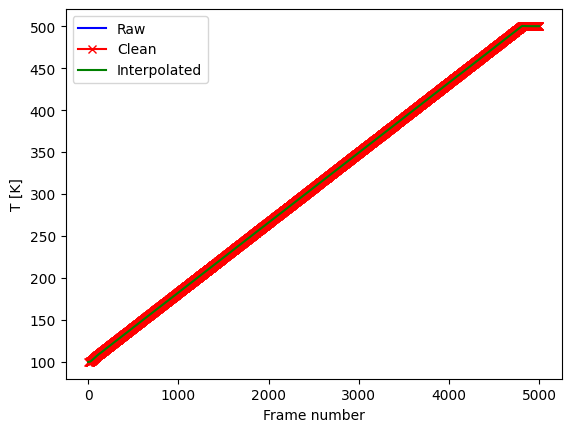

In [10]:
# In some fast data collections the temperature is not updated for each frame and thus multiple frames will have the same value.

# Plot raw data
plt.figure()
frame_numbers = np.linspace(frame_range[0],frame_range[1]-1,frame_range[1]-frame_range[0]).astype(int)
plt.plot(frame_numbers, temperature[frame_range[0]:frame_range[1]], label = 'Raw', color='blue')

# Clean duplicate values:
temperature_clean=np.zeros(len(temperature))
for i in range(len(temperature)):
    if temperature[len(temperature)-(i+1)] == temperature[len(temperature)-(i+2)]:
        temperature_clean[len(temperature)-(i+1)] = np.NaN
    else:
        temperature_clean[len(temperature)-(i+1)] = temperature[len(temperature)-(i+1)]
        
# Plot 'clean' values
plt.plot(frame_numbers, temperature_clean[frame_range[0]:frame_range[1]], label='Clean', marker='x', color='red')

# Clean values may be interpolated to give better values for each frame
# create mask to skip nan values in the interpolation
mask = np.ma.masked_invalid(temperature_clean)
from scipy.interpolate import interp1d

all_frame_numbers = np.linspace(0,len(temperature)-1,len(temperature))
temperature_interp = interp1d(all_frame_numbers[~mask.mask], temperature_clean[~mask.mask], kind='linear')

# Plot interpolated values
plt.plot(frame_numbers, temperature_interp(frame_numbers), label='Interpolated', color='green')
plt.ylabel('T [K]')
plt.xlabel('Frame number')
plt.legend()